In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [5]:
ZEN_csv = Path("../SaaS_Data/Zendesk_ZEN.csv")

In [6]:
ZEN_df = pd.read_csv(ZEN_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [7]:
ZEN_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,63.040001,63.669998,60.799999,61.970001,61.970001,1752700
2018-08-16,62.770000,62.810001,61.090000,62.200001,62.200001,1523300
2018-08-17,62.099998,62.150002,60.849998,61.709999,61.709999,911500
2018-08-20,61.560001,62.119999,60.910000,61.700001,61.700001,864300
2018-08-21,61.919998,63.049999,61.680000,61.830002,61.830002,681200


In [8]:
ZEN_df.sort_index(ascending=True, inplace=True)

In [9]:
ZEN_df = ZEN_df.rename(columns={'Close': 'Close'})
ZEN_df = ZEN_df[['Close']]
ZEN_df

,Close
Date,
2018-08-15,61.970001
2018-08-16,62.200001
2018-08-17,61.709999
2018-08-20,61.700001
2018-08-21,61.830002
...,...
2021-08-09,128.050003
2021-08-10,125.760002
2021-08-11,124.550003


In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [12]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(ZEN_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[61.970001 62.200001 61.709999 61.700001 61.830002 63.400002 64.589996
  66.760002 67.010002 67.309998 69.230003 69.400002 68.889999 69.68
  67.980003 67.940002 69.059998 69.949997 70.660004 70.669998 70.550003
  71.940002 67.690002 68.510002 67.230003 67.970001 67.309998 68.550003
  71.370003 71.160004 70.809998 71.       69.199997 67.639999 67.879997
  66.669998 65.800003 63.669998 63.290001 60.07     59.169998 61.610001
  60.639999 63.220001 62.959999 61.700001 57.82     58.740002 59.310001
  55.700001 56.91     55.68     54.189999 53.759998 54.970001 55.150002
  55.169998 53.330002 53.009998 57.639999 55.549999 54.400002 53.189999
  52.549999 53.099998 55.970001 54.919998 48.369999 49.369999 51.799999
  53.099998 54.16     52.549999 57.439999 58.290001 59.43     61.389999
  58.48     59.880001 58.400002 58.599998 58.529999 60.610001 61.169998
  59.860001 55.91     55.419998 55.810001 53.639999 51.25     51.509998
  56.029999 56.869999 57.25     58.369999 57.59    

In [13]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [14]:
y_train

array([[62.560001],
       [62.959999],
       [62.450001],
       [61.549999],
       [63.009998],
       [62.939999],
       [63.709999],
       [65.029999],
       [64.040001],
       [64.400002],
       [64.519997],
       [65.790001],
       [65.910004],
       [64.629997],
       [65.93    ],
       [67.529999],
       [69.080002],
       [68.989998],
       [68.599998],
       [72.400002],
       [73.269997],
       [76.379997],
       [76.790001],
       [78.470001],
       [77.489998],
       [78.970001],
       [78.730003],
       [78.07    ],
       [77.160004],
       [77.059998],
       [78.839996],
       [79.059998],
       [79.169998],
       [79.32    ],
       [79.019997],
       [80.269997],
       [77.010002],
       [77.040001],
       [75.209999],
       [75.919998],
       [77.199997],
       [79.209999],
       [81.400002],
       [81.699997],
       [82.959999],
       [82.599998],
       [82.919998],
       [83.879997],
       [84.019997],
       [85.639999],


In [15]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [18]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [20]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
4/4 [==============================] - 10s 455ms/step - loss: 0.1402
Epoch 2/20
4/4 [==============================] - 2s 468ms/step - loss: 0.0496
Epoch 3/20
4/4 [==============================] - 2s 459ms/step - loss: 0.0558
Epoch 4/20
4/4 [==============================] - 2s 512ms/step - loss: 0.0233
Epoch 5/20
4/4 [==============================] - 2s 464ms/step - loss: 0.0321
Epoch 6/20
4/4 [==============================] - 2s 441ms/step - loss: 0.0175
Epoch 7/20
4/4 [==============================] - 1s 351ms/step - loss: 0.0206
Epoch 8/20
4/4 [==============================] - 2s 411ms/step - loss: 0.0153
Epoch 9/20
4/4 [==============================] - 1s 354ms/step - loss: 0.0177
Epoch 10/20
4/4 [==============================] - 1s 353ms/step - loss: 0.0150
Epoch 11/20
4/4 [==============================] - 2s 398ms/step - loss: 0.0137
Epoch 12/20
4/4 [==============================] - 1s 339ms/step - loss: 0.0138
Epoch 13/20
4/4 [==============================]

In [21]:
model.evaluate(X_test, y_test, verbose=0)

0.14905387163162231

In [22]:
predicted = model.predict(X_test)

In [23]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [24]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [26]:
ZEN_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ZEN_df.index[-len(real_prices): ])

ZEN_actual_predicted.head()

,Actual,Predicted
Date,,
2020-07-31,100.519997,90.936623
2020-08-03,91.150002,91.493210
2020-08-04,92.309998,91.913162
2020-08-05,91.379997,92.180504
2020-08-06,91.480003,92.256508


In [27]:
ZEN_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,128.619995,121.882790
2021-08-10,128.050003,120.878418
2021-08-11,125.760002,119.837029
2021-08-12,124.550003,118.719078
2021-08-13,123.830002,117.608276


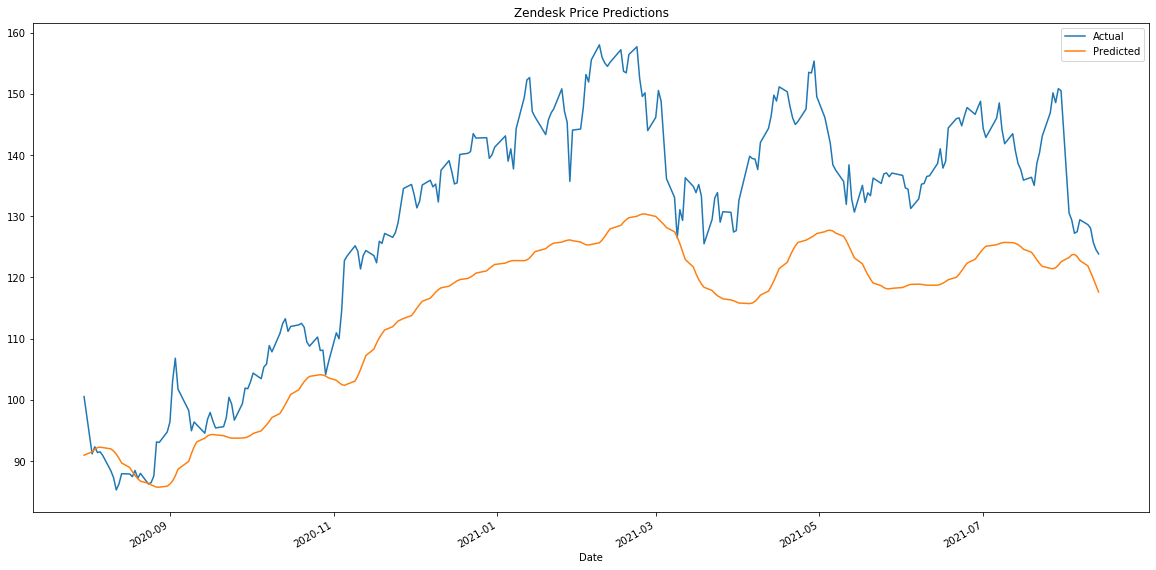

In [29]:
ZEN_actual_predicted.plot(figsize=(20,10), title="Zendesk Price Predictions")